In [1]:
from utils import get_file_paths, get_training_files_paths
# from losses import focal_tversky

from tf_model_related import AttentionUnet, Losses
from preprocessing import orthosSequence#  LoadPreprocessImages

import matplotlib.pyplot as plt
import json
from tqdm import tqdm
import numpy as np
import cv2 
from skimage import color

# import tensorflow as tf 
from tensorflow import keras
# from tensorflow.keras.preprocessing.image import load_img
from keras import backend as K

from sklearn.model_selection import train_test_split

from segmentation_mask_overlay import overlay_masks

In [2]:
with open('config.json') as f:
    config = json.load(f)

In [3]:
epochnum = 2
test_split = 0.1
img_size = 256
batch_size = 32

In [4]:
max_samples = 350
divide_by_dept = True

In [5]:
input_img_paths, target_img_paths = get_file_paths(divide_by_dept=divide_by_dept)

In [6]:
img_paths, mask_paths = get_training_files_paths(input_img_paths, target_img_paths, max_samples=max_samples)

In [7]:
import pandas as pd
import os
pd.Series(img_paths).apply(lambda x: os.path.basename(x)[4:6]).value_counts()#.sum()

49    88
61    88
14    87
35    87
Name: count, dtype: int64

In [8]:
train_input_img_paths, val_input_img_paths, train_target_img_paths, val_target_img_paths = train_test_split(img_paths, mask_paths, test_size=test_split, shuffle=True)

In [9]:
# Instantiate data Sequences for each split
train_gen = orthosSequence(batch_size=batch_size, input_img_paths=train_input_img_paths, target_img_paths=train_target_img_paths, rgb=True, add_noise=True)
val_gen = orthosSequence(batch_size=batch_size, input_img_paths=val_input_img_paths, target_img_paths=val_target_img_paths, rgb=True, add_noise=True)

In [10]:
train_gen.__getitem__(0)[0].shape

(32, 256, 256, 3)

In [11]:
idx = 0

In [12]:
val_gen.__getitem__(0)[0][idx].min()

0.050859347

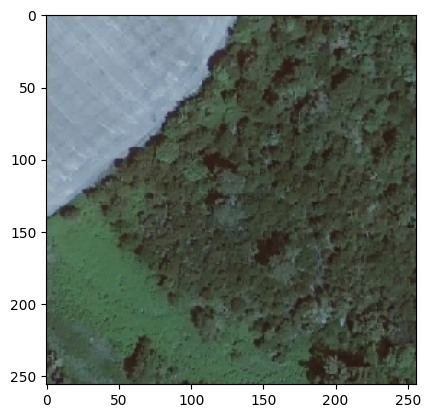

In [13]:
plt.imshow(val_gen.__getitem__(0)[0][idx])

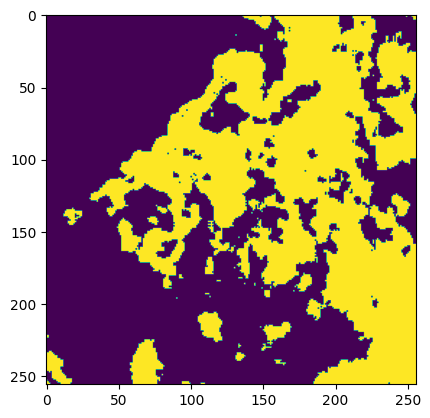

In [14]:
plt.imshow(val_gen.__getitem__(0)[1][idx])

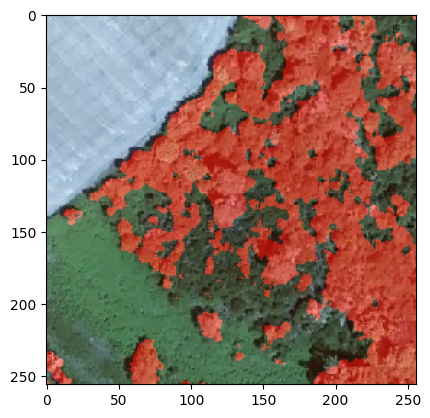

In [15]:
fig = overlay_masks(val_gen.__getitem__(0)[0][idx], val_gen.__getitem__(0)[1][idx], colors=[(1, 0, 0)])
plt.imshow(fig)

In [16]:
from IPython.display import clear_output

class PerformancePlotCallback(keras.callbacks.Callback):
    def __init__(self, val_gen):
        self.imgs = val_gen.__getitem__(1)[0]
        self.trues = val_gen.__getitem__(1)[1]
        
    def on_epoch_end(self, epoch, logs={}):
        # clear_output(wait=True)
        y_preds = self.model.predict(self.imgs)
        plt.figure(figsize=(12, 12))

        title = ["Input Image", "True Mask", "Predicted Mask"]
        display_list = [self.imgs[0], self.trues[0], np.round(y_preds[0])]
        for i in range(len(display_list)):
            plt.subplot(1, len(display_list), i + 1)
            plt.title(title[i])
            plt.imshow(keras.utils.array_to_img(display_list[i]))
            plt.axis("off")
        plt.show()
        print("\nSample Prediction after epoch {}\n".format(epoch + 1))

In [17]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()
attention_unet = AttentionUnet((config['img_size'], config['img_size']) + (3,))
model = attention_unet.build_model()

In [18]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_1 (Conv2D)            (None, 256, 256, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv1_1_bn (BatchNormaliza  (None, 256, 256, 32)         128       ['conv1_1[0][0]']             
 tion)                                                                                            
                                                                                                  
 conv1_1_act (Activation)    (None, 256, 256, 32)         0         ['conv1_1_bn[0][0]']      

In [19]:
LR = 1e-3

model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR), loss=Losses.focal_tversky, metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.IoU(num_classes=2, target_class_ids=[1])])
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR), loss=Combo_loss, metrics=[keras.metrics.BinaryAccuracy()])
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR), loss=keras.losses.BinaryCrossentropy(), metrics=[keras.metrics.BinaryAccuracy()])
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR), loss=keras.losses.BinaryFocalCrossentropy(), metrics=[keras.metrics.BinaryAccuracy()])

callbacks = [
    PerformancePlotCallback(val_gen),
    keras.callbacks.EarlyStopping(patience=5, start_from_epoch=5),
    # keras.callbacks.ModelCheckpoint(config['models_dir']+f"35_14_61_49/2012/intermediary_AttentionUnet_{int(len(train_input_img_paths))}_trains_wavelet_noise_{epochnum}_epochs_img_size_{img_size}_LR_{LR}_BS_{batch_size}_FocalTverskyLoss".replace('.', '_').replace('-','_') + ".h5", save_best_only=True)
]

In [20]:
len(train_input_img_paths)

315

Epoch 1/2
1/1 [==============================] - 2s 2s/steploss: 0.2446 - binary_accuracy: 0.7476 - io_u: 0.0000e+


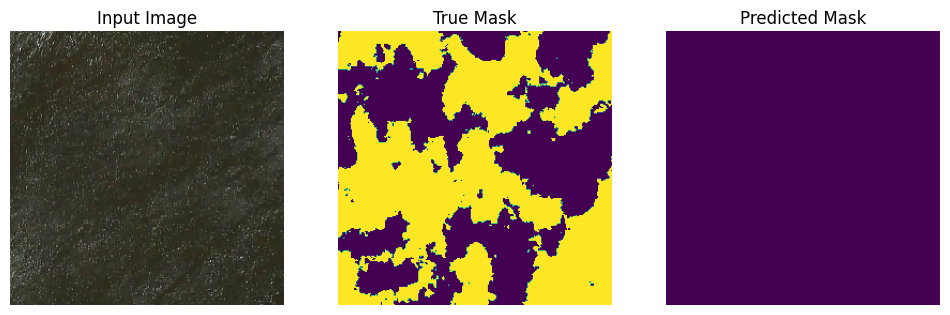


Sample Prediction after epoch 1

9/9 [==============================] - 60s 6s/step - loss: 0.2446 - binary_accuracy: 0.7476 - io_u: 0.0000e+00 - val_loss: 0.4855 - val_binary_accuracy: 0.6471 - val_io_u: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 1s 1s/steploss: 0.1173 - binary_accuracy: 0.8015 - io_u: 0.13


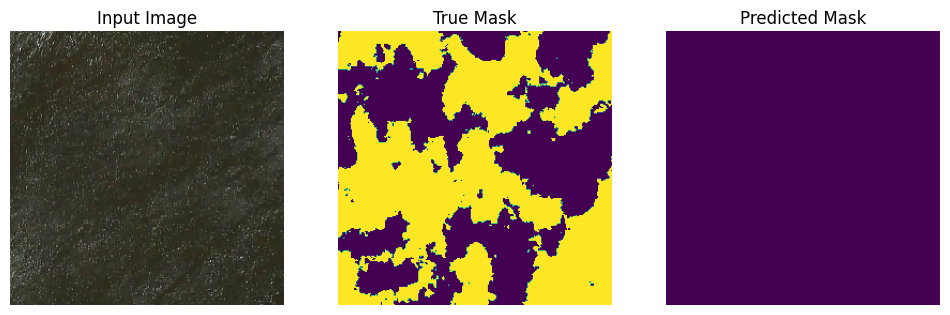


Sample Prediction after epoch 2

9/9 [==============================] - 48s 5s/step - loss: 0.1173 - binary_accuracy: 0.8015 - io_u: 0.1319 - val_loss: 0.5054 - val_binary_accuracy: 0.6470 - val_io_u: 0.0000e+00


In [21]:
hist = model.fit(train_gen, epochs=epochnum, validation_data=val_gen, callbacks=callbacks)

In [65]:
model.save((config['models_dir'] + '35_14_61_49/2012/AttentionUnet_' + str(int(len(train_input_img_paths))) + '_trains' + '_epochs_' + str(epochnum) + f'_no_noise_img_size_{img_size}_LR_{LR}_BS_{batch_size}_FocalTverskyLoss_96acc_8414iou').replace('.', '_').replace('-','_') + '.h5')
# model = keras.models.load_model(model_dir+'Resnet50-U-net_train-65536_seed-1337')
# model = keras.models.load_model('output_models/Resnet50_Unet_4000_train_epochs_5_with_equalizing_with_normalizing_img_size_256_LR_0_0001_BS_64_FocalLoss.h5')

In [29]:
val_preds = model.predict(val_gen)

15/15 [==============================] - 74s 5s/step


In [68]:
idx = 19

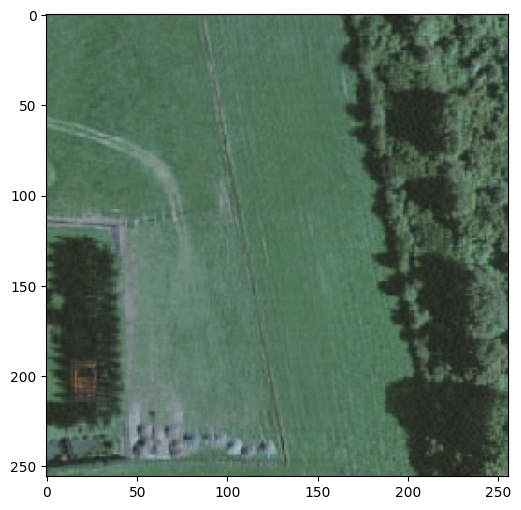

In [69]:
ax, _ = plt.subplots(figsize=(6, 6))
plt.imshow(val_gen.__getitem__(0)[0][idx])

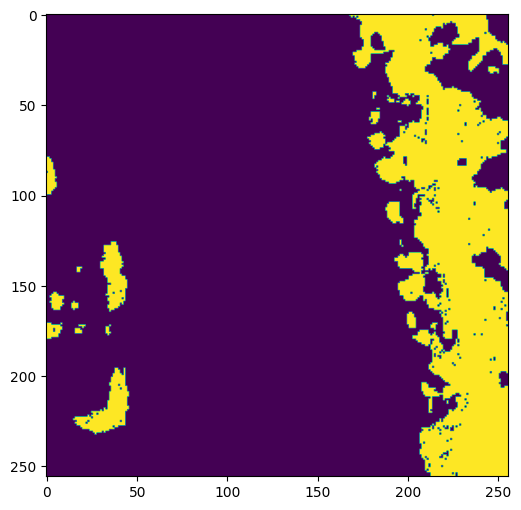

In [70]:
ax, _ = plt.subplots(figsize=(6, 6))
plt.imshow(val_gen.__getitem__(0)[1][idx])

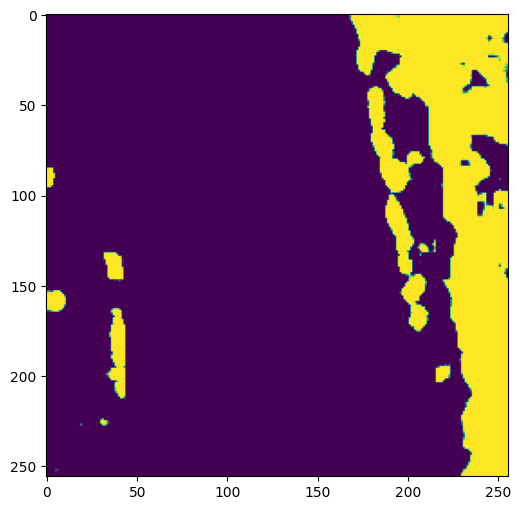

In [71]:
ax, _ = plt.subplots(figsize=(6, 6))
plt.imshow(val_preds[idx])

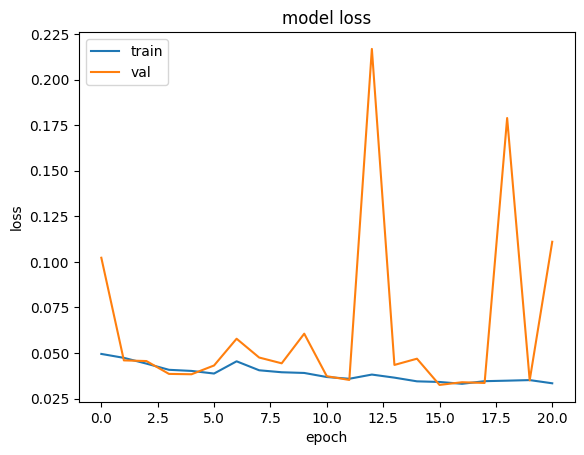

In [25]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

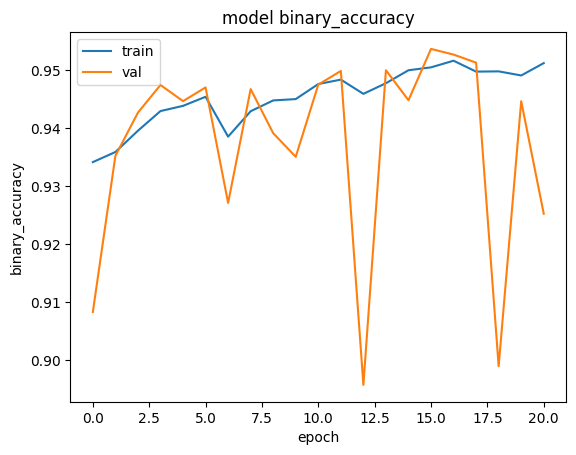

In [26]:
plt.plot(hist.history['binary_accuracy'])
plt.plot(hist.history['val_binary_accuracy'])
plt.title('model binary_accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

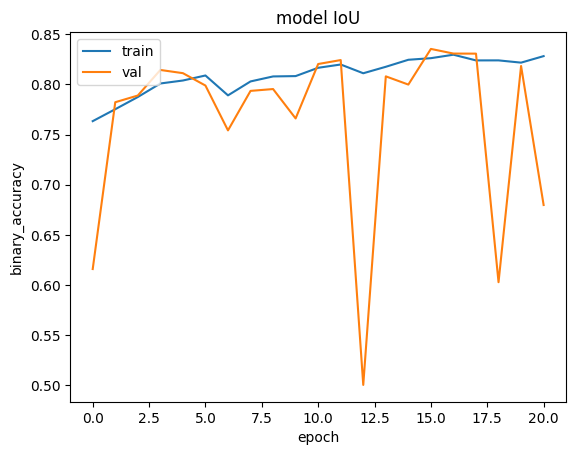

In [27]:
plt.plot(hist.history['io_u'])
plt.plot(hist.history['val_io_u'])
plt.title('model IoU')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [28]:
hist.history

{'loss': [0.049497976899147034,
  0.04734141379594803,
  0.04418397694826126,
  0.04078911244869232,
  0.04017634689807892,
  0.03874509036540985,
  0.04544992372393608,
  0.04053090885281563,
  0.03944605588912964,
  0.0390617810189724,
  0.036831311881542206,
  0.03587843105196953,
  0.038177527487277985,
  0.03649137541651726,
  0.03446594253182411,
  0.03412036597728729,
  0.03311469405889511,
  0.034552354365587234,
  0.03483174741268158,
  0.03514846786856651,
  0.033394381403923035],
 'binary_accuracy': [0.9341834783554077,
  0.9359242916107178,
  0.9395958185195923,
  0.9429855346679688,
  0.9438846111297607,
  0.9454489350318909,
  0.9385782480239868,
  0.9429575204849243,
  0.9448201060295105,
  0.9450523257255554,
  0.9476481676101685,
  0.9484097957611084,
  0.9459579586982727,
  0.9477887749671936,
  0.950023889541626,
  0.9505242705345154,
  0.9516690969467163,
  0.9497891068458557,
  0.9498329162597656,
  0.949124276638031,
  0.9512551426887512],
 'io_u': [0.763429224491

# Loaded model 

In [49]:
from from_preprocessing_to_training import Losses, AttentionUnet
from utils import load_custom_model

In [45]:
losses = Losses()

In [46]:
custom_objects_list=[attention_unet.expend_as, attention_unet.AttnGatingBlock, attention_unet.UnetConv2D, attention_unet.UnetGatingSignal, losses.tversky, losses.focal_tversky]

In [47]:
model_path = 'output_models/intermediary_AttentionUnet_B&W_11988_trains_no_equalizing_with_normalizing_with_1/5_SVD_noise_20_epochs_img_size_256_LR_0_001_BS_32_FocalTverskyLoss_95acc_80iuo.h5'

In [51]:
loaded_model = load_custom_model(model_path=model_path, custom_objects_list=custom_objects_list)


In [52]:
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv1_1 (Conv2D)            (None, 256, 256, 32)         320       ['input_1[0][0]']             
                                                                                                  
 conv1_1_bn (BatchNormaliza  (None, 256, 256, 32)         128       ['conv1_1[0][0]']             
 tion)                                                                                            
                                                                                                  
 conv1_1_act (Activation)    (None, 256, 256, 32)         0         ['conv1_1_bn[0][0]']      

In [72]:
loaded_model.evaluate(val_gen)

41/41 [==============================] - 127s 3s/step - loss: 0.0409 - binary_accuracy: 0.9496 - io_u: 0.8042


[0.040902651846408844, 0.9496197700500488, 0.8041701316833496]

In [53]:
val_preds_intermediary = loaded_model.predict(val_gen)

41/41 [==============================] - 112s 3s/step


In [70]:
idx = 10

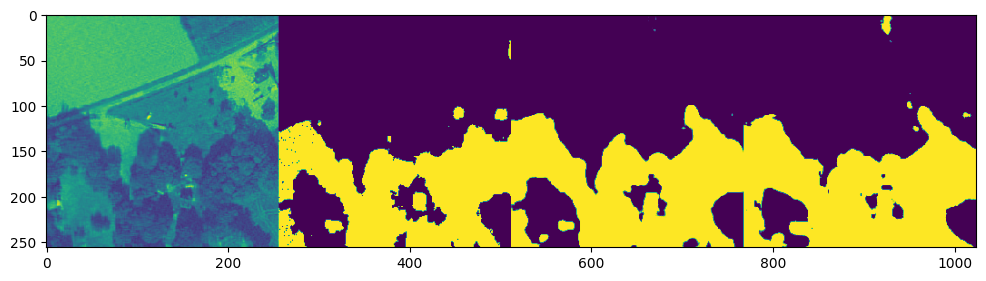

In [71]:
ax, _ = plt.subplots(figsize=(12, 12))
plt.imshow(np.hstack([val_gen.__getitem__(0)[0][idx], val_gen.__getitem__(0)[1][idx], val_preds_intermediary[idx], val_preds[idx]]))

# Stat predictions

In [ ]:
import pandas as pd
df = pd.read_csv('vignettes/stat_older_vignettes.csv', index_col='Unnamed: 0')

In [ ]:
df

# Tests divers

In [54]:
import cv2
import matplotlib.pyplot as plt
from skimage.restoration import denoise_wavelet, denoise_bilateral, calibrate_denoiser, cycle_spin, denoise_tv_bregman, denoise_tv_chambolle
from skimage.metrics import peak_signal_noise_ratio
from skimage.color import rgb2gray
from skimage.util import random_noise
import numpy as np

In [10]:
img_2020 = cv2.imread('donnees/BDORTHO/ORTHOHR_1-0_RVB-0M20_JP2-E080_LAMB93_D035_2020-01-01/ORTHOHR/1_DONNEES_LIVRAISON_2021-06-00121/OHR_RVB_0M20_JP2-E080_LAMB93_D35-2020/35-2020-0305-6780-LA93-0M20-E080.jp2')

In [11]:
img_2020.shape

(25000, 25000, 3)

In [24]:
img_2020_resized_1 = cv2.resize(img_2020, (10000, 10000), interpolation=cv2.INTER_AREA)
img_2020_resized_2 = img_2020_resized_1[:100, 100:200] # 288*6:288*7, :288]

In [15]:
img_1993 = cv2.imread('donnees/BDORTHO/1993_OK/35-1993-0305-6780-LA93.TIF')

In [16]:
resized_img_1993 = img_1993[:288, :288]

In [126]:
10e3

10000.0

In [127]:
512**2

262144

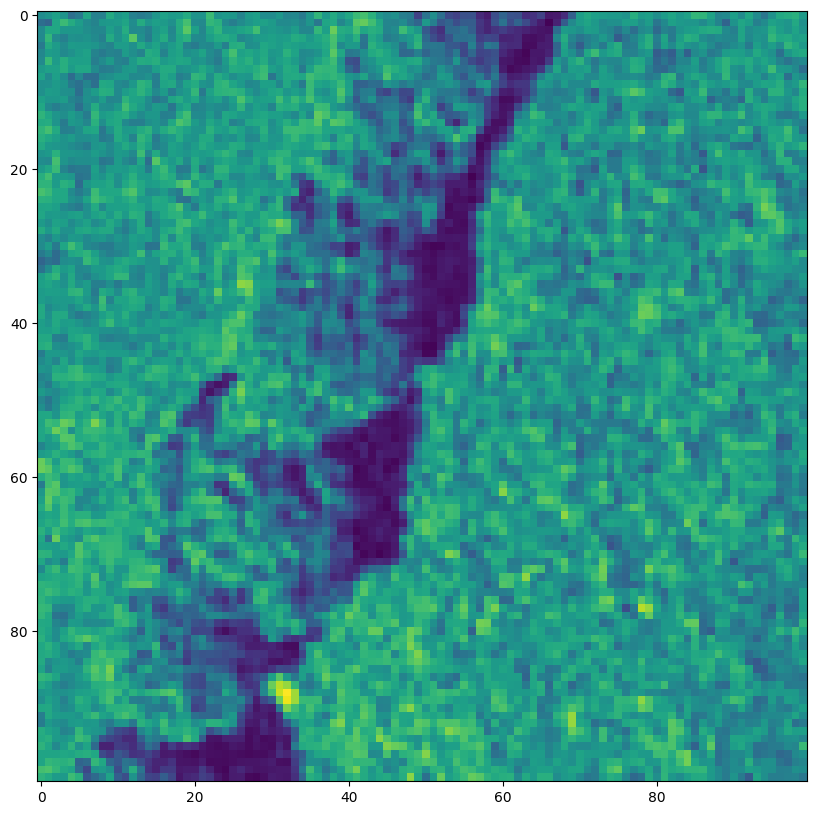

In [17]:
plt.subplots(figsize=(10, 10))
plt.imshow(resized_img_1993[:,:,0][:100, 100:200])

In [133]:
10e-4

0.001

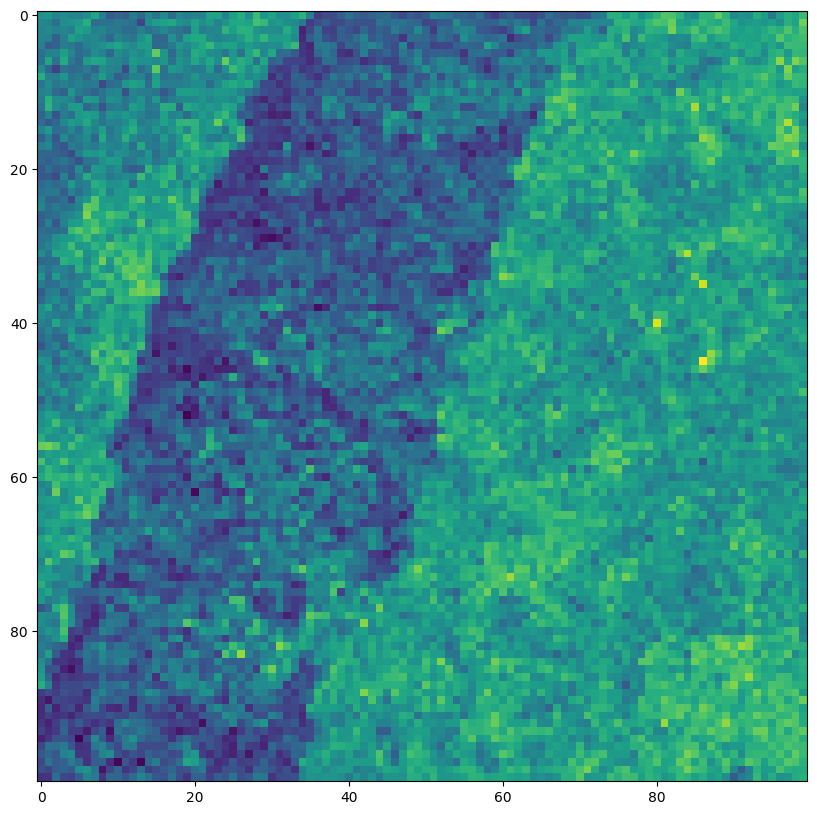

In [131]:
plt.subplots(figsize=(10, 10))
plt.imshow(random_noise(rgb2gray(img_2020_resized_2), mode='gaussian', var=0.001))

In [60]:
7/255

0.027450980392156862

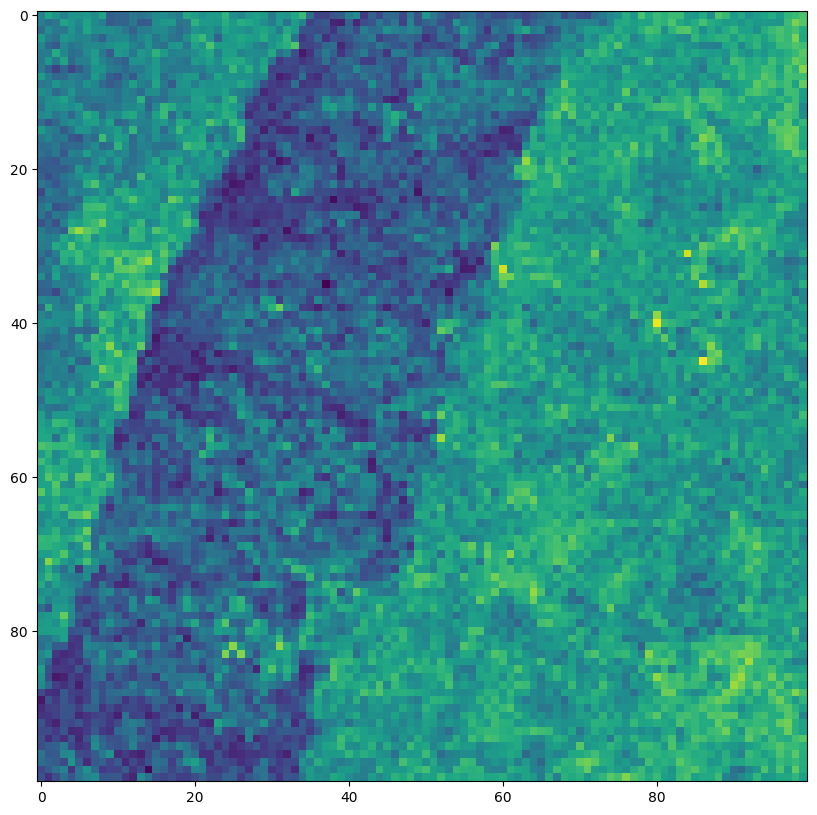

In [84]:
img = rgb2gray(img_2020_resized_2)
gaussian = np.random.normal(0, 0.03, (img.shape))
img = img + gaussian
plt.subplots(figsize=(10, 10))
plt.imshow(img)

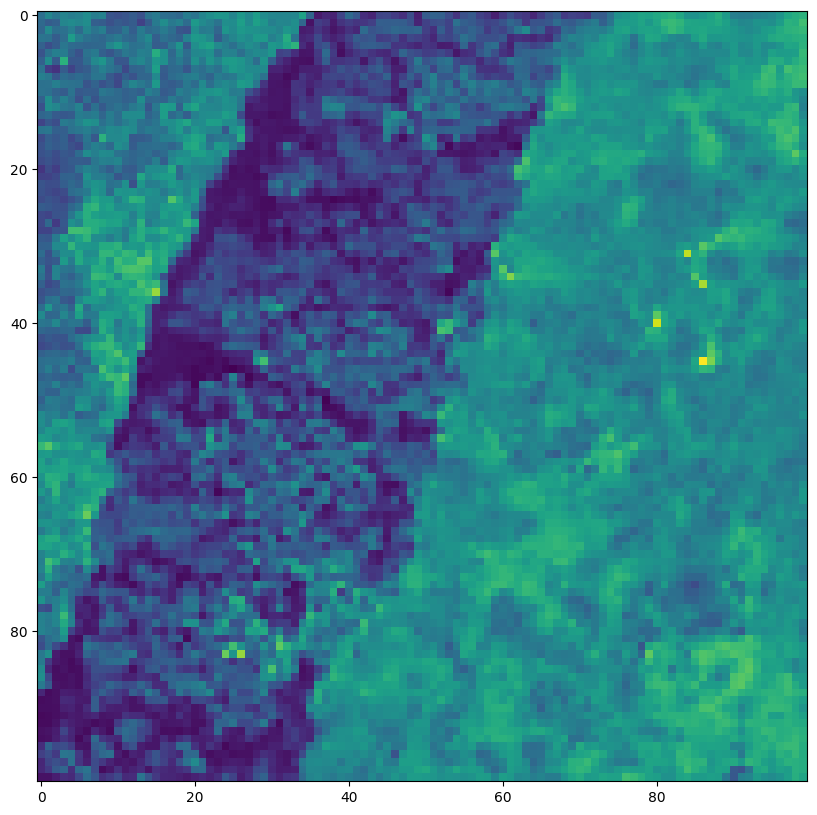

In [28]:
plt.subplots(figsize=(10, 10))
plt.imshow(rgb2gray(img_2020_resized_2))

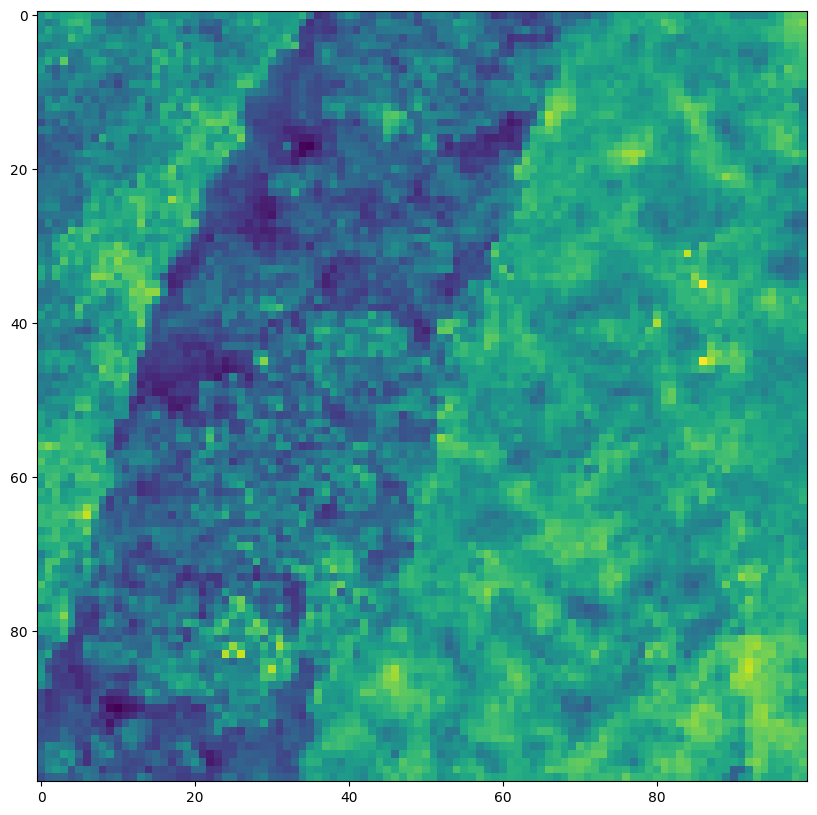

In [125]:
from skimage.util import random_noise
from skimage.io import imsave
from skimage.transform import resize
import random
import numpy as np

im_arr = rgb2gray(img_2020_resized_2) # Original image - use gray image for testing

rows, cols = im_arr.shape

val = 0.01 #random.uniform(0.036, 0.107) # Use constant variance (for testing).

# Full resolution
noise_im1 = np.zeros((rows, cols))
noise_im1 = random_noise(noise_im1, mode='gaussian', var=val**2, clip=False)

# Half resolution
noise_im2 = np.zeros((rows//2, cols//2))
noise_im2 = random_noise(noise_im2, mode='gaussian', var=(val*2)**2, clip=False)  # Use val*2 (needs tuning...)
noise_im2 = resize(noise_im2, (rows, cols))  # Upscale to original image size

# Quarter resolution
noise_im3 = np.zeros((rows//4, cols//4))
noise_im3 = random_noise(noise_im3, mode='gaussian', var=(val*4)**2, clip=False)  # Use val*4 (needs tuning...)
noise_im3 = resize(noise_im3, (rows, cols))  # What is the interpolation method?

noise_im = noise_im1 + noise_im2 + noise_im3  # Sum the noise in multiple resolutions (the mean of noise_im is around zero).

noisy_img = im_arr + noise_im  # Add noise_im to the input image.

noisy_img = np.round((255 * noisy_img)).clip(0, 255).astype(np.uint8)
plt.subplots(figsize=(10, 10))
plt.imshow(noisy_img)

In [16]:
img_2020 = cv2.imread('donnees/BDORTHO/ORTHOHR_1-0_RVB-0M20_JP2-E080_LAMB93_D035_2020-01-01/ORTHOHR/1_DONNEES_LIVRAISON_2021-06-00121/OHR_RVB_0M20_JP2-E080_LAMB93_D35-2020/35-2020-0305-6780-LA93-0M20-E080.jp2')

In [17]:
img_2020.shape

(25000, 25000, 3)

In [26]:
img_2020_resized_1 = cv2.resize(img_2020, (10000, 10000), interpolation=cv2.INTER_AREA)
img_2020_resized_2 = img_2020_resized_1[:288, :288]

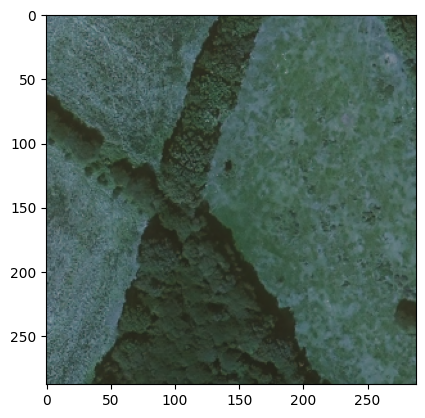

In [28]:
plt.imshow(img_2020_resized_2)